# Pivot tables y joins

## Tabla de Contenidos

    I. Clase 2: Pivot tables y joins
        I. Parámetros y extracción de datos
        II. Pivot table
            I. Contar casos a partir de un registro
            II. Crear un panel a partir de un registro
        III. Concat
        IV. .str
            I. .str.replace()
            II. .str.split()
        V. .map
        VI. Merge

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

plt.style.use('ggplot')
%matplotlib inline

## Parámetros y extracción de datos

In [38]:
# input

CASOS_URL = "covid_casos.zip"
DETERMINACIONES_URL = "covid_determinaciones.csv"

# output
PANEL_CASOS_PATH = "covid19-casos-panel.csv"

Si los sacamos de internet, podemos usar directamente la URL de cualquier CSV. Siempre es buena práctica guardar una copia por si en algún momento una URL deja de estar disponible.

In [39]:
converters = {
    "residencia_provincia_id": lambda x: str(x).zfill(2),
    "departamento_provincia_id": lambda x: str(x).zfill(3),
    "codigo_indec_provincia": lambda x: str(x).zfill(2),
    "codigo_indec_departamento": lambda x: str(x).zfill(3),
}

# lee los datos 
casos = pd.read_csv(CASOS_URL, converters=converters)
determinaciones = pd.read_csv(DETERMINACIONES_URL, converters=converters)


In [40]:
casos.sample(5)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,Clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
52654,865299,F,56.0,Años,Argentina,Corrientes,Empedrado,Corrientes,NaN,2020-04-28,...,NaN,NO,18,Público,Caso Descartado,Descartado,18,2020-04-27,42,2020-06-20
4392,770742,F,42.0,Años,Argentina,CABA,COMUNA 14,CABA,2020-03-22,2020-03-26,...,NaN,NO,2,Privado,Caso Descartado,Descartado,02,2020-04-08,14,2020-06-20
154253,1008844,F,28.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-05-31,2020-06-02,...,NaN,NO,2,Público,Caso confirmado - Activo,Confirmado,02,2020-06-03,0,2020-06-20
106259,947566,F,11.0,Años,Argentina,CABA,COMUNA 1,CABA,2020-05-16,2020-05-20,...,NaN,NO,2,Público,Caso confirmado - No activo (por tiempo de evo...,Confirmado,02,2020-05-19,1,2020-06-20
88438,922528,F,20.0,Años,Argentina,Buenos Aires,Malvinas Argentinas,Formosa,NaN,2020-05-15,...,NaN,NO,34,Público,Caso Descartado,Descartado,06,2020-05-13,515,2020-06-20


## Pivot table

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

La función de `DataFrame.pivot_table` permite crear una tabla dinámica (de la misma forma que se podría hacer en una planilla de cálculo como Excel) fácilmente, eligiendo qué columnas se quieren mostrar en:

* **índice (index)**: lo que se usa para abrir los datos en filas.
* **columnas (columns)**: lo que se usa para abrir los datos en columnas.
* **valores (values)**: las variables que se quieren abrir en filas y columnas.

Y se puede elegir una o más funciones de agregación para aplicar a los valores cuando son agregados.

### Contar casos a partir de un registro

**Casos**

En el dataset de **casos** nos enfrentamos a un **registro**: el dataset es una lista de casos, donde cada fila es un "caso". No tenemos columnas con variables agregadas, tenemos la materia prima sobre la cual se construyen las estadísticas o las agregaciones de cualquier tipo.

Las tablas dinámicas son una buena forma de agregar! En este caso la primera agregación obvia es _contar casos_. Tratemos de **contar la cantidad de casos de Covid por provincia**. 

In [41]:
casos.columns

Index(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
       'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
       'fallecido', 'fecha_fallecimiento', 'asistencia_respiratoria_mecanica',
       'carga_provincia_id', 'origen_financiamiento', 'Clasificacion',
       'clasificacion_resumen', 'residencia_provincia_id', 'fecha_diagnostico',
       'residencia_departamento_id', 'ultima_actualizacion'],
      dtype='object')

In [42]:
# busquemos las columnas que vamos a necesitar usar primero
casos.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,Clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,672064,M,52.0,Años,Argentina,Buenos Aires,Florencio Varela,Buenos Aires,2020-05-29,NaN,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2020-06-01,274,2020-06-20
1,717629,F,46.0,Años,Argentina,Buenos Aires,Pergamino,Buenos Aires,2020-01-29,2020-01-31,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,NaN,623,2020-06-20
2,717926,F,41.0,Años,Argentina,CABA,COMUNA 12,CABA,2020-01-23,2020-01-31,...,NaN,NO,2,Público,Caso Invalidado Epidemiologicamente,Descartado,02,NaN,12,2020-06-20
3,718029,F,52.0,Años,Argentina,Buenos Aires,La Plata,Buenos Aires,2020-01-29,2020-01-31,...,NaN,NO,6,Público,Caso Invalidado Epidemiologicamente,Descartado,06,NaN,441,2020-06-20
4,718055,F,34.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,2020-01-16,2020-01-31,...,NaN,NO,2,Privado,Caso Descartado,Descartado,02,2020-02-11,0,2020-06-20


In [43]:
#Valores unicos por columna
casos.residencia_provincia_nombre.unique()

array(['Buenos Aires', 'CABA', 'Córdoba', 'Mendoza', 'SIN ESPECIFICAR',
       'Tierra del Fuego', 'Formosa', 'Corrientes', 'Santa Fe',
       'Entre Ríos', 'La Rioja', 'Río Negro', 'Chaco', 'San Luis',
       'San Juan', 'Santa Cruz', 'Tucumán', 'Neuquén', 'La Pampa',
       'Catamarca', 'Chubut', 'Salta', 'Santiago del Estero', 'Jujuy',
       'Misiones'], dtype=object)

In [44]:
for col in casos.columns:
    if col.startswith("fecha"):
        print(col)

fecha_inicio_sintomas
fecha_apertura
fecha_internacion
fecha_cui_intensivo
fecha_fallecimiento
fecha_diagnostico


In [45]:
casos.columns[5].startswith("fecha")

False

In [46]:
casos.clasificacion_resumen.value_counts()

clasificacion_resumen
Descartado        189801
Confirmado         41191
Sospechoso         20375
Sin Clasificar         6
Name: count, dtype: int64

In [47]:
casos[casos.clasificacion_resumen == "Confirmado"].head(3)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,Clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
42,734634,M,43.0,Años,Argentina,CABA,COMUNA 1,CABA,2020-02-28,2020-03-02,...,NaN,NO,2,Privado,Caso confirmado - No activo (por laboratorio y...,Confirmado,02,2020-03-03,1,2020-06-20
51,736018,M,58.0,Años,Argentina,Córdoba,San Justo,Córdoba,2020-03-02,2020-03-03,...,NaN,NO,14,Privado,Caso confirmado - No activo (por laboratorio y...,Confirmado,14,2020-03-06,140,2020-06-20
59,736711,F,67.0,Años,Argentina,Buenos Aires,Tres de Febrero,Buenos Aires,2020-02-27,2020-03-04,...,NaN,NO,6,Público,Caso confirmado - No activo (por laboratorio y...,Confirmado,06,2020-03-06,840,2020-06-20


In [48]:
casos_provincias = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    #columns="sexo",
    index="residencia_provincia_nombre",
    values="edad",
    aggfunc="max"
)
casos_provincias.sort_values("edad", ascending=False)

,edad
residencia_provincia_nombre,
Buenos Aires,120.0
CABA,120.0
Córdoba,97.0
Río Negro,95.0
La Rioja,94.0
Misiones,93.0
Chaco,91.0
Mendoza,91.0
Neuquén,89.0


Primer reflejo que siempre tenés que tener: controlar el resultado con algún parámetro conocido (en lo posible). En este caso, tratemos de ver si la suma de casos tiene sentido o no.

In [49]:
casos_provincias.edad.mean()

84.75

**Ejercicio:** crear una tabla contando la cantidad de casos fallecidos por residencia. 

In [50]:
casos_provincias = casos[~casos.fecha_fallecimiento.isnull()].pivot_table(
    index=["residencia_provincia_nombre"],
    values=["id_evento_caso"],
    aggfunc="count"
)
casos_provincias.sort_values("id_evento_caso", ascending=False)

,id_evento_caso
residencia_provincia_nombre,
Buenos Aires,1350
CABA,764
Chaco,160
Entre Ríos,82
Córdoba,58
Mendoza,56
Río Negro,49
Santa Fe,36
La Rioja,21


### Crear un panel a partir de un registro

Una estructura muy común de dataset de **panel** tiene:

* 1 o más variables (generalmente numéricas)
* 1 dimensión de apertura temporal
* 1 o más dimensiones de apertura _no temporales_

Convertir registros en paneles, es un paso lógico en el procesamiento de datos primarios hacia la construcción de productos estadísticos o analíticos. Encapsula una parte del esfuerzo que conviene hacer bien de una sola vez, y luego utilizar el panel fácilmente para la mayoría de nuestras necesidades. 

En este caso vamos a elegir cuáles son nuestras variables de interés para **construir el panel de casos de Covid**:

* provincia
* sexo
* fecha (tiene que haber una dimensión temporal)

In [51]:
casos_panel = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-03-06,1
1,02,CABA,F,2020-03-13,1
2,02,CABA,F,2020-03-14,3
3,02,CABA,F,2020-03-15,2
4,02,CABA,F,2020-03-16,2
...,...,...,...,...,...
1722,99,SIN ESPECIFICAR,M,2020-06-18,2
1723,99,SIN ESPECIFICAR,M,2020-06-19,6
1724,99,SIN ESPECIFICAR,M,2020-06-20,1
1725,99,SIN ESPECIFICAR,NR,2020-05-30,1


Ahora realizar distintos gráficos es muy fácil! Sólo hay que hacer una tabla dinámica sobre nuestro panel eligiendo las variables.

In [52]:
casos_evolucion_genero = casos_panel.pivot_table(
    columns="sexo",
    index="fecha_diagnostico",
    values="id_evento_caso",
    aggfunc="sum"
)
casos_evolucion_genero

sexo,F,M,NR
fecha_diagnostico,,,
2020-03-03,NaN,1.0,NaN
2020-03-06,2.0,4.0,NaN
2020-03-07,NaN,1.0,NaN
2020-03-08,NaN,2.0,NaN
2020-03-09,5.0,1.0,NaN
...,...,...,...
2020-06-16,755.0,833.0,11.0
2020-06-17,841.0,899.0,6.0
2020-06-18,831.0,840.0,5.0


<Axes: xlabel='fecha_diagnostico'>

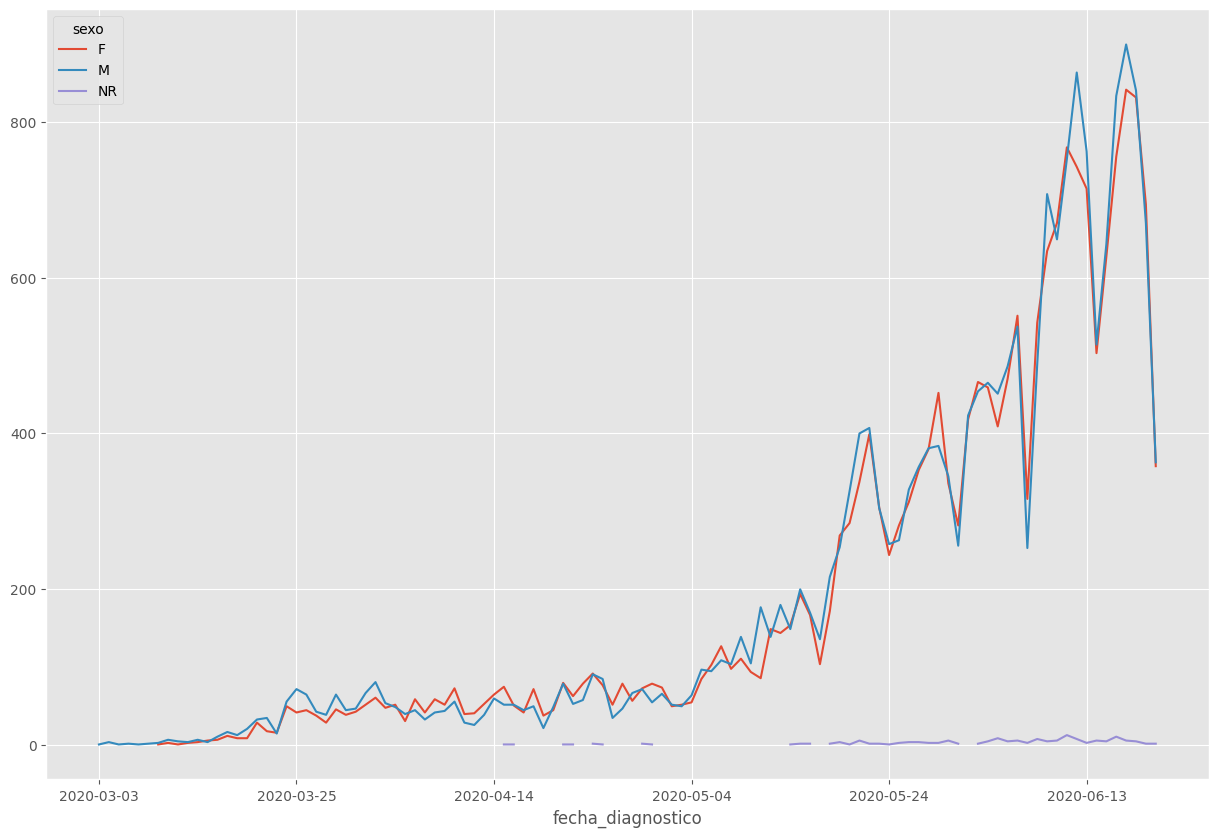

In [53]:
casos_evolucion_genero.plot(figsize=(15, 10))

**Ejercicio:** graficar la evolución de casos por provincia.

<Axes: xlabel='fecha_diagnostico'>

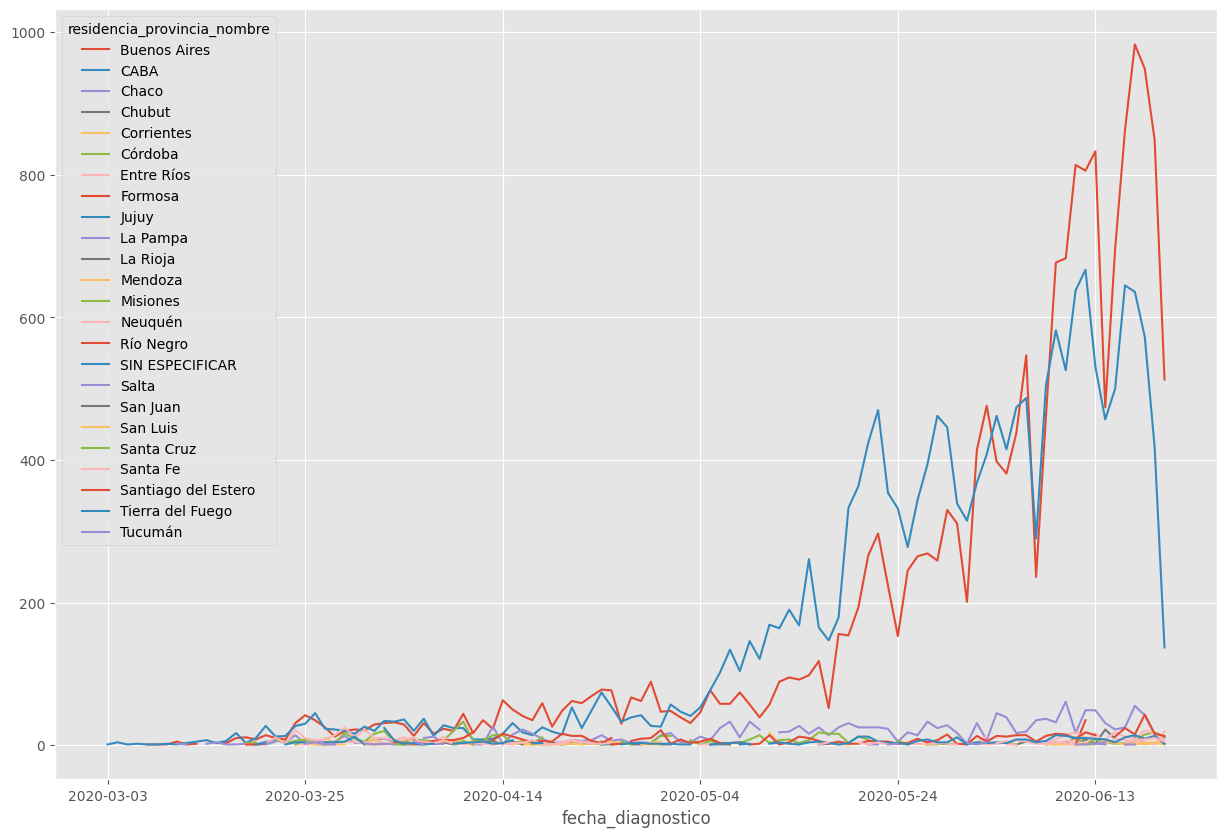

In [54]:
casos_evolucion_genero = casos_panel.pivot_table(
    columns="residencia_provincia_nombre",
    index="fecha_diagnostico",
    values="id_evento_caso",
    aggfunc="sum"
)
casos_evolucion_genero.plot(figsize=(15, 10))

## Concat 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

Pero ahora queremos graficar las curvas de casos confirmados y fallecidos, y nos damos cuenta de que a nuestro panel construido para trabajar le falta una nueva dimensión de apertura de la variable **casos**: el **estado** del caso.

Tenemos que agregar la variable **estado** a nuestro panel, con por lo menos dos estados: **confirmados** y **fallecios**. Para esto vamos a construir paneles **idénticos** para cada una de las variables y concatenarlos.

In [55]:
casos_panel_confirmados = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-03-06,1
1,02,CABA,F,2020-03-13,1
2,02,CABA,F,2020-03-14,3
3,02,CABA,F,2020-03-15,2
4,02,CABA,F,2020-03-16,2


Ahora armemos el panel de casos fallecidos con la misma estructura.

In [56]:
casos_panel_fallecidos = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_fallecimiento"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_fallecimiento,id_evento_caso
0,02,CABA,F,2020-03-25,2
1,02,CABA,F,2020-03-28,1
2,02,CABA,F,2020-04-06,1
3,02,CABA,F,2020-04-07,1
4,02,CABA,F,2020-04-09,2


Y ahora necesitamos modificar ambos paneles para que tengan la misma estructura, y así poder concatenarlos.

* Agregar una columna para la dimensión "estado"
* Renombrar las columnas para que sigan teniendo sentido cuando sumemos información

In [57]:
casos_panel_confirmados["estado"] = "confirmados"
casos_panel_confirmados = casos_panel_confirmados.rename(columns={
    "fecha_diagnostico": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-03-06,1,confirmados
1,02,CABA,F,2020-03-13,1,confirmados
2,02,CABA,F,2020-03-14,3,confirmados
3,02,CABA,F,2020-03-15,2,confirmados
4,02,CABA,F,2020-03-16,2,confirmados


In [58]:
casos_panel_fallecidos["estado"] = "fallecidos"
casos_panel_fallecidos = casos_panel_fallecidos.rename(columns={
    "fecha_fallecimiento": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-03-25,2,fallecidos
1,02,CABA,F,2020-03-28,1,fallecidos
2,02,CABA,F,2020-04-06,1,fallecidos
3,02,CABA,F,2020-04-07,1,fallecidos
4,02,CABA,F,2020-04-09,2,fallecidos


In [59]:
casos_panel_confirmados.shape

(1727, 6)

In [60]:
casos_panel_fallecidos.shape

(460, 6)

Y ahora el momento de la verdad! Generemos un solo panel con todos los datos.

In [61]:
casos_panel2 = pd.concat([casos_panel_confirmados, casos_panel_fallecidos] #apila los datos
                         , axis=0 #une los datos
                         
                        )
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-03-06,1,confirmados
1,02,CABA,F,2020-03-13,1,confirmados
2,02,CABA,F,2020-03-14,3,confirmados
3,02,CABA,F,2020-03-15,2,confirmados
4,02,CABA,F,2020-03-16,2,confirmados
...,...,...,...,...,...,...
455,90,Tucumán,F,2020-04-08,1,fallecidos
456,90,Tucumán,M,2020-03-29,1,fallecidos
457,90,Tucumán,M,2020-04-01,1,fallecidos
458,99,SIN ESPECIFICAR,M,2020-05-25,1,fallecidos


Ya podemos graficar fallecidos

In [62]:
casos_evolucion_genero2 = casos_panel2[
    casos_panel2.estado == "fallecidos"
].pivot_table(
    columns="sexo",
    index="fecha",
    values="casos",
    aggfunc="sum"
).reset_index()
casos_evolucion_genero2

sexo,fecha,F,M,NR
0,2020-03-07,NaN,1.0,NaN
1,2020-03-13,NaN,1.0,NaN
2,2020-03-18,NaN,1.0,NaN
3,2020-03-21,1.0,NaN,NaN
4,2020-03-24,NaN,3.0,NaN
...,...,...,...,...
88,2020-06-16,7.0,13.0,NaN
89,2020-06-17,11.0,13.0,NaN
90,2020-06-18,7.0,12.0,1.0
91,2020-06-19,3.0,6.0,NaN


<Axes: >

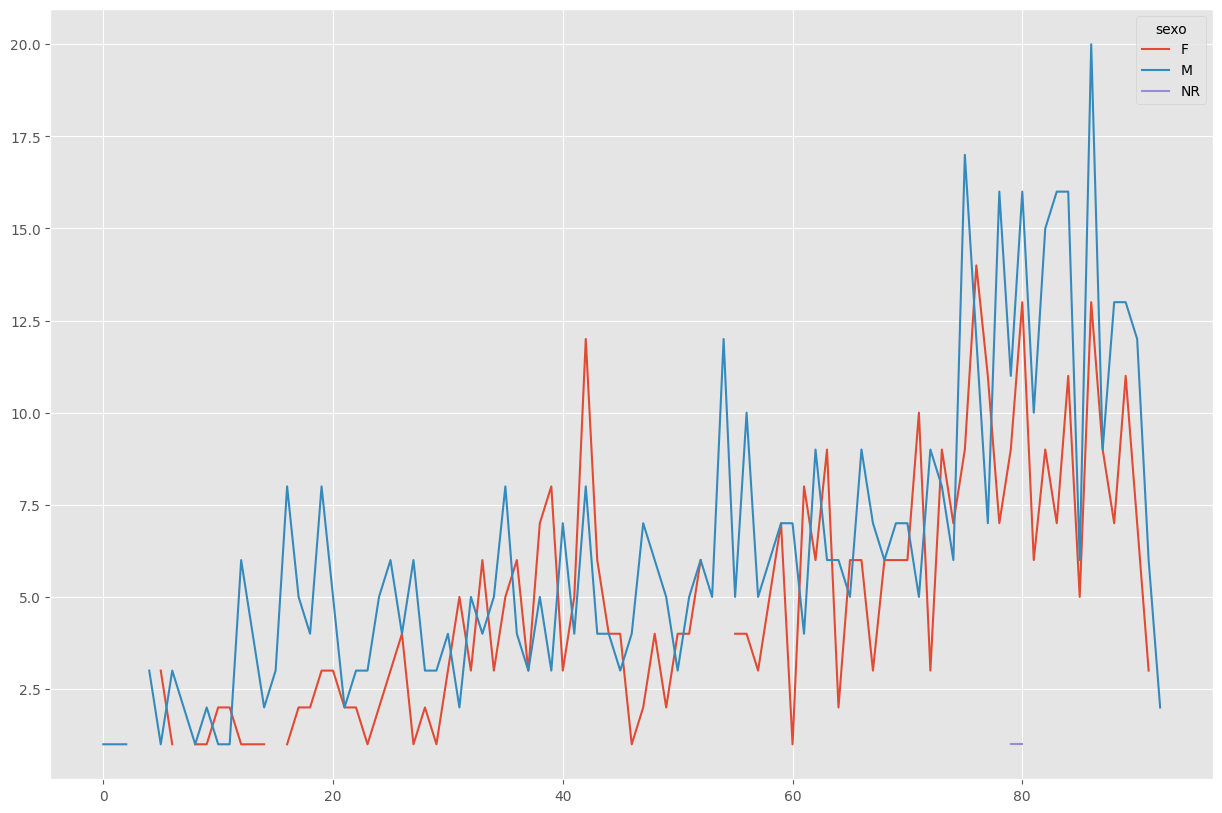

In [63]:
casos_evolucion_genero2.plot(figsize=(15,10))

## .str

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html

Todas las columnas (Series) de un data frame tienen diferentes métodos asociados que se pueden utilzar para hacer transformaciones rápidamente.

Hay un grupo de ellos accesible a través del atributo `str` (`Series.str`) que implementa las funciones usuales de Python sobre strings, para una columna de valores de texto.

### .str.replace() 

Si queremos graficar la evolución de casos por sexo, pero queremos una leyenda con la palabra completa, tal vez necesitemos reemplazar los valores usados en el dataset por otros.

In [64]:
casos_panel2.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-03-06,1,confirmados
1,02,CABA,F,2020-03-13,1,confirmados
2,02,CABA,F,2020-03-14,3,confirmados
3,02,CABA,F,2020-03-15,2,confirmados
4,02,CABA,F,2020-03-16,2,confirmados


In [65]:
casos_panel2["sexo"] = casos_panel2.sexo.str.replace(
    "F", "Femenino"
).replace(
    "M", "Masculino"
).replace(
    "NR", "No responde"
)

In [66]:
casos_panel2.sexo.value_counts()

sexo
Masculino      1124
Femenino        977
No responde      86
Name: count, dtype: int64

###  .str.split()

Si queremos agrupar por mes, tal vez necesitamos partir la fecha en tres partes.

In [67]:
casos_panel2.fecha.str.split("/")

0      [2020-03-06]
1      [2020-03-13]
2      [2020-03-14]
3      [2020-03-15]
4      [2020-03-16]
           ...     
455    [2020-04-08]
456    [2020-03-29]
457    [2020-04-01]
458    [2020-05-25]
459    [2020-06-08]
Name: fecha, Length: 2187, dtype: object

In [68]:
casos_panel2.fecha.str.split("-")

0      [2020, 03, 06]
1      [2020, 03, 13]
2      [2020, 03, 14]
3      [2020, 03, 15]
4      [2020, 03, 16]
            ...      
455    [2020, 04, 08]
456    [2020, 03, 29]
457    [2020, 04, 01]
458    [2020, 05, 25]
459    [2020, 06, 08]
Name: fecha, Length: 2187, dtype: object

Para poder asignar esas 3 partes a 3 columnas diferentes a la vez, debe agregarse otro `.str` al final.

In [69]:
casos_panel2["anio", "mes", "dia"] = casos_panel2.fecha.str.split("-")

In [70]:
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,"(anio, mes, dia)"
0,02,CABA,Femenino,2020-03-06,1,confirmados,"[2020, 03, 06]"
1,02,CABA,Femenino,2020-03-13,1,confirmados,"[2020, 03, 13]"
2,02,CABA,Femenino,2020-03-14,3,confirmados,"[2020, 03, 14]"
3,02,CABA,Femenino,2020-03-15,2,confirmados,"[2020, 03, 15]"
4,02,CABA,Femenino,2020-03-16,2,confirmados,"[2020, 03, 16]"
...,...,...,...,...,...,...,...
455,90,Tucumán,Femenino,2020-04-08,1,fallecidos,"[2020, 04, 08]"
456,90,Tucumán,Masculino,2020-03-29,1,fallecidos,"[2020, 03, 29]"
457,90,Tucumán,Masculino,2020-04-01,1,fallecidos,"[2020, 04, 01]"
458,99,SIN ESPECIFICAR,Masculino,2020-05-25,1,fallecidos,"[2020, 05, 25]"


## .map

Tal vez notaron lo impráctico que puede resultar el método `.str.replace()` cuando la lista de reemplazos sea larga. Para este caso existe el método `.map()`, al que se le puede pasar un diccionario con los reemplazos.

In [71]:
casos_panel2["sexo"] = casos_panel2.sexo.map({
    "Masculino": "Masc",
    "Femenino": "Fem",
    "No responde": "Sin especificar"
})

In [72]:
casos_panel2.sexo.value_counts()

sexo
Masc               1124
Fem                 977
Sin especificar      86
Name: count, dtype: int64

## Merge 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

"Mergear", "joinear" o cruzar dos datasets, implica elegir una o más columnas que estos tengan en común y utilizarlas para cruzar ambas tablas en base a la coincidencia de valores entre ambas. Existen varios tipos de _joins_ según cuál es el resultado que nos interesa obtener al final con la cruza:

* **left join**: preserva el 100% de las filas que tiene la tabla _de la izquierda_ del merge, y agrega las columnas del dataset _de la derecha_ con los valores (cuando hay una coincidencia) o las llena con valores nulos (cuando no hay coincidencia). Si el dataset de la derecha tiene valores para filas que no están presentes en el dataset de la izquierda, simplemente no se utilizan. El dataset resultado tiene la misma cantidad de filas que el dataset de la izquierda.
* **right join**: es igual que el anterior, pero se preservan las filas del dataset de la derecha en lugar de las del de la izquierda.
* **inner join**: sólo se mantienen aquellas filas que coinciden _en ambos datasets_. Si alguna fila no tiene coincidencia en uno de los dos, se descarta. El dataset final tiene igual cantidad o menos filas que el dataset más grande.
* **outer join**: se preservan todas las filas. Si hay coincidencia, se cruzan, y si no hay coincidencia se apilan llenando con valores nulos.

El tipo de join más común que van a utilizar la mayoría de las veces es el **left join**, cuyo caso de uso es "tengo una tabla, y quiero enriquecerla con nuevas columnas".

In [73]:
Image(url= "joins.png")

Ahora, queremos calcular y graficar un indicador utilizado en algunos análisis que es la cantidad de testeos sobre la cantidad de casos confirmados.

Este indicador nos dice cuántos tests están siendo necesarios para identificar cada caso positivo de Covid. Para esto vamos a necesitar cruzar los datos de **determinaciones** con los de **casos**.

Hasta ahora nuestro panel tenía una sola variable! Pero ya es hora de que le agreguemos otra: `tests`.

In [74]:
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,"(anio, mes, dia)"
0,02,CABA,Fem,2020-03-06,1,confirmados,"[2020, 03, 06]"
1,02,CABA,Fem,2020-03-13,1,confirmados,"[2020, 03, 13]"
2,02,CABA,Fem,2020-03-14,3,confirmados,"[2020, 03, 14]"
3,02,CABA,Fem,2020-03-15,2,confirmados,"[2020, 03, 15]"
4,02,CABA,Fem,2020-03-16,2,confirmados,"[2020, 03, 16]"
...,...,...,...,...,...,...,...
455,90,Tucumán,Fem,2020-04-08,1,fallecidos,"[2020, 04, 08]"
456,90,Tucumán,Masc,2020-03-29,1,fallecidos,"[2020, 03, 29]"
457,90,Tucumán,Masc,2020-04-01,1,fallecidos,"[2020, 04, 01]"
458,99,SIN ESPECIFICAR,Masc,2020-05-25,1,fallecidos,"[2020, 05, 25]"


¿Cómo hacemos esto? Para cruzar (o "joinear") un dataset con otro, necesitamos definir un conjunto de columnas común por el cual hacerlo, esto a veces se llama **clave primaria** (o "primary key"). 

La clave primaria de una tabla es el conjunto de columnas necesarias para identificar a una sola fila de la tabla. Si miramos nuestro último panel, vemos que necesitamos las columnas **provincia**, **sexo**, **fecha** y **estado**.

In [75]:
determinaciones

,fecha,provincia,codigo_indec_provincia,departamento,codigo_indec_departamento,localidad,codigo_indec_localidad,origen_de_financiamiento,tipo,ultima_actualizacion,total,positivos
0,2020-02-11,CABA,02,COMUNA 4,004,PARQUE PATRICIOS,10,Público,Nacional,2020-06-20,2,NaN
1,2020-02-20,CABA,02,COMUNA 4,004,PARQUE PATRICIOS,10,Público,Nacional,2020-06-20,1,NaN
2,2020-02-20,Buenos Aires,06,Bahía Blanca,056,BAHIA BLANCA,10,Privado,Privado,2020-06-20,1,NaN
3,2020-02-27,CABA,02,COMUNA 4,004,PARQUE PATRICIOS,10,Público,Nacional,2020-06-20,4,NaN
4,2020-02-28,CABA,02,COMUNA 4,004,PARQUE PATRICIOS,10,Público,Nacional,2020-06-20,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6732,2020-06-20,Santa Fe,82,Rosario,084,ROSARIO,270,Privado,Privado,2020-06-20,1,1.0
6733,2020-06-20,Santa Fe,82,Rosario,084,ROSARIO,270,Público,Municipal,2020-06-20,19,3.0
6734,2020-06-20,Tierra del Fuego,94,Ushuaia,014,USHUAIA,20,Público,Provincial,2020-06-20,3,NaN
6735,2020-06-20,Tucumán,90,Cruz Alta,014,BANDA DEL RIO SALI,20,Público,Provincial,2020-06-20,2,NaN


Sin embargo el panel de "determinaciones" sólo comparte las columnas **fecha** y **provincia**, así que necesitamos generar dos paneles con esa clave primaria para poder cruzarlos.

In [76]:
casos_confirmados_provincias = casos_panel2[
    casos_panel2.estado == "confirmados"
].pivot_table(
    index=["residencia_provincia_id", "fecha"],
    values="casos",
    aggfunc="sum"
).reset_index()

casos_confirmados_provincias

,residencia_provincia_id,fecha,casos
0,02,2020-03-03,1
1,02,2020-03-06,4
2,02,2020-03-07,1
3,02,2020-03-08,2
4,02,2020-03-09,1
...,...,...,...
1006,99,2020-06-16,11
1007,99,2020-06-17,14
1008,99,2020-06-18,9
1009,99,2020-06-19,13


Siempre recuerden controlar el resultado!

In [77]:
casos_confirmados_provincias.casos.sum()

41191

Ahora hacemos un panel de determinaciones con la misma estructura.

In [78]:
determinaciones_panel = determinaciones.pivot_table(
    index=["codigo_indec_provincia", "fecha"],
    values="total",
    aggfunc="sum"
).reset_index()

determinaciones_panel

,codigo_indec_provincia,fecha,total
0,02,2020-02-11,2
1,02,2020-02-20,1
2,02,2020-02-27,4
3,02,2020-02-28,10
4,02,2020-03-02,5
...,...,...,...
1885,94,2020-06-20,3
1886,99,2020-05-22,1
1887,99,2020-06-03,1
1888,99,2020-06-12,1


In [79]:
determinaciones_panel.total.sum()

280326

Llegó el momento del join! Recordemos que el objetivo es terminar con un solo panel, donde haya ahora dos variables: **casos** y **tests** ; con apertura por las dos dimensiones que comparten los datasets: **provincia** y **fecha**.

Para esto vamos a usar la función `DataFrame.merge()`.

In [80]:
casos_tests = casos_confirmados_provincias.merge(
    determinaciones_panel,
    left_on=["residencia_provincia_id", "fecha"],
    right_on=["codigo_indec_provincia", "fecha"]
    , how='right' #left, right, inner
)

casos_tests

,residencia_provincia_id,fecha,casos,codigo_indec_provincia,total
0,NaN,2020-02-11,NaN,02,2
1,NaN,2020-02-20,NaN,02,1
2,NaN,2020-02-27,NaN,02,4
3,NaN,2020-02-28,NaN,02,10
4,NaN,2020-03-02,NaN,02,5
...,...,...,...,...,...
1885,NaN,2020-06-20,NaN,94,3
1886,99,2020-05-22,5.0,99,1
1887,99,2020-06-03,4.0,99,1
1888,99,2020-06-12,10.0,99,1


Bien! Noten que si la columna coincide en nombre, quedará una sola columna, pero si los nombres son diferentes tendremos una columna duplicada (que no queremos). Además deberíamos clarificar el nombre de la segunda variable.

In [81]:
casos_tests = casos_tests.drop(
    columns=["codigo_indec_provincia"]
)
casos_tests

,residencia_provincia_id,fecha,casos,total
0,NaN,2020-02-11,NaN,2
1,NaN,2020-02-20,NaN,1
2,NaN,2020-02-27,NaN,4
3,NaN,2020-02-28,NaN,10
4,NaN,2020-03-02,NaN,5
...,...,...,...,...
1885,NaN,2020-06-20,NaN,3
1886,99,2020-05-22,5.0,1
1887,99,2020-06-03,4.0,1
1888,99,2020-06-12,10.0,1


In [82]:
casos_tests = casos_tests.rename(
    columns={"total": "tests"}
)
casos_tests

,residencia_provincia_id,fecha,casos,tests
0,NaN,2020-02-11,NaN,2
1,NaN,2020-02-20,NaN,1
2,NaN,2020-02-27,NaN,4
3,NaN,2020-02-28,NaN,10
4,NaN,2020-03-02,NaN,5
...,...,...,...,...
1885,NaN,2020-06-20,NaN,3
1886,99,2020-05-22,5.0,1
1887,99,2020-06-03,4.0,1
1888,99,2020-06-12,10.0,1


¿Por qué no usamos concat en lugar de merge, y agregamos una columna que se llame `variable` y tenga los valores "casos" y "tests"? 

Esto también hubiera sido una estructura de panel posible, con sus ventajas y desventajas. Si tuviéramos una _gran cantidad_ de variables tal vez es mejor elegir esa estructura de dataset **más vertical**, pero si tenemos pocas, tal vez es mejor que cada variable sea una columna.

¿No son casos confirmados y casos fallecidos variables distintas también? Sí, podría pensarse así. Pero en este caso sí es más claro que se puede modelar como una variable **casos** con una dimensión de apertura que es el **estado** del caso.

Ahora queremos calcular una nueva variable: tests x caso confirmado.

In [83]:
casos_tests["porc_confirmado"] = round(casos_tests.casos / casos_tests.tests, 2)*100

casos_tests

,residencia_provincia_id,fecha,casos,tests,porc_confirmado
0,NaN,2020-02-11,NaN,2,NaN
1,NaN,2020-02-20,NaN,1,NaN
2,NaN,2020-02-27,NaN,4,NaN
3,NaN,2020-02-28,NaN,10,NaN
4,NaN,2020-03-02,NaN,5,NaN
...,...,...,...,...,...
1885,NaN,2020-06-20,NaN,3,NaN
1886,99,2020-05-22,5.0,1,500.0
1887,99,2020-06-03,4.0,1,400.0
1888,99,2020-06-12,10.0,1,1000.0


<Axes: xlabel='fecha'>

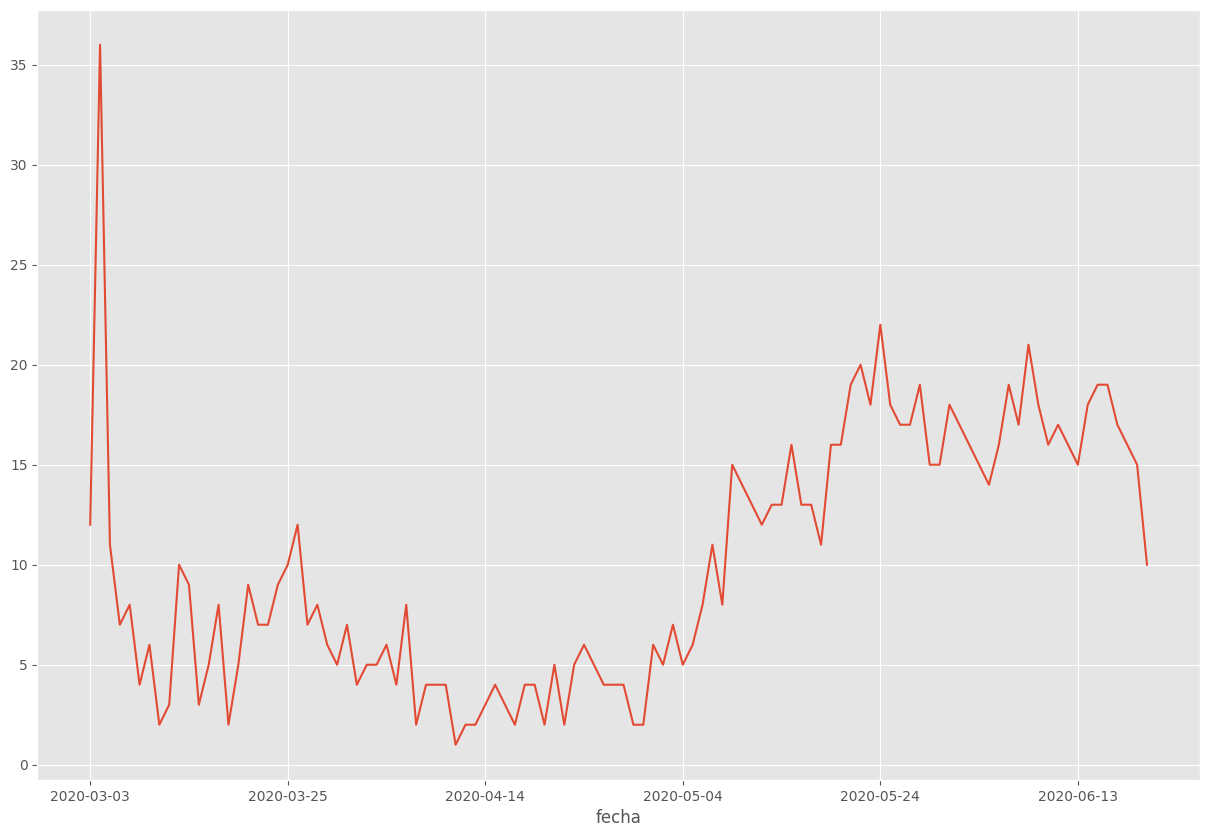

In [84]:
casos_tests[
    casos_tests.residencia_provincia_id == "02"
].set_index(
    "fecha"
).porc_confirmado.plot(figsize=(15, 10))

Esta variable puede tener variadas interpretaciones. ¿Qué significa si baja? ¿Se están haciendo los testeos focalizados en zonas con brotes? ¿Se necesitan hacer más tests para estar seguro de que se detecta la cantidad de casos necesarios para localizar los brotes?

Hay muchas interpretaciones posibles, y probablemente requieran de una interpretación más sofisticada. Se lo dejamos a los expertos!